<h1> F1 Race Strategy Prediction Model </h1>

 <h3> Imports and Configuration </h3>

In [1]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import os
import requests
import time
import xgboost as xgb
import requests
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

<h3> Load CSV </h3>

In [2]:
# Defining data directory
data_dir = 'f1 data'

# Load CSV files
print("\nLoading CSV files...")
lap_times = pd.read_csv(os.path.join(data_dir, 'lap_times.csv'))
races = pd.read_csv(os.path.join(data_dir, 'races.csv'))
drivers = pd.read_csv(os.path.join(data_dir, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(data_dir, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(data_dir, 'circuits.csv'))
pit_stops = pd.read_csv(os.path.join(data_dir, 'pit_stops.csv'))

print(f"lap_times.csv: {len(lap_times):,} rows")
print(f"races.csv: {len(races):,} rows")
print(f"drivers.csv: {len(drivers):,} rows")
print(f"constructors.csv: {len(constructors):,} rows")
print(f"circuits.csv: {len(circuits):,} rows")
print(f"pit_stops.csv: {len(pit_stops):,} rows")



Loading CSV files...
lap_times.csv: 589,081 rows
races.csv: 1,125 rows
drivers.csv: 861 rows
constructors.csv: 212 rows
circuits.csv: 77 rows
pit_stops.csv: 11,371 rows


<h3> Merge and create laps dataset </h3> 

In [3]:
results = pd.read_csv(os.path.join(data_dir, 'results.csv'))
print(f"Loaded results.csv: {len(results):,} rows")

race_laps = lap_times.copy()

# Merging with races to get year, circuit, date info
race_laps = race_laps.merge(
    races[['raceId', 'year', 'round', 'circuitId', 'name', 'date']], 
    on='raceId', 
    how='left'
)
print(f"Merged with races")

# Merging with results to get constructorId for each driver in each race
race_laps = race_laps.merge(
    results[['raceId', 'driverId', 'constructorId']],
    on=['raceId', 'driverId'],
    how='left'
)
print(f"Merged with results to get team info")

# Merging with drivers to get driver info
race_laps = race_laps.merge(
    drivers[['driverId', 'driverRef', 'code', 'forename', 'surname']], 
    on='driverId', 
    how='left'
)
race_laps['Driver'] = race_laps['code'].fillna(race_laps['surname'])
print(f"Merged with drivers")

# Merging with constructors to get team info
race_laps = race_laps.merge(
    constructors[['constructorId', 'name', 'constructorRef']], 
    on='constructorId', 
    how='left',
    suffixes=('_race', '_constructor')
)
race_laps = race_laps.rename(columns={'name_constructor': 'Team'})
print(f"Merged with constructors")

# Merging with circuits to get circuit info
race_laps = race_laps.merge(
    circuits[['circuitId', 'circuitRef', 'name', 'location', 'country']], 
    on='circuitId', 
    how='left',
    suffixes=('', '_circuit')
)
race_laps = race_laps.rename(columns={
    'name_circuit': 'Circuit',
    'location': 'Location',
    'country': 'Country'
})
print(f"Merged with circuits")

# Renaming columns to match previous structure
race_laps = race_laps.rename(columns={
    'year': 'Year',
    'name_race': 'EventName',
    'lap': 'LapNumber',
    'position': 'Position',
    'milliseconds': 'LapTimeMs'
})

# Converting lap times to milliseconds
race_laps['LapTimeSec'] = race_laps['LapTimeMs'] / 1000

# Fixing the Circuit column name
race_laps = race_laps.rename(columns={'name': 'Circuit'})
print("Renamed 'name' to 'Circuit'")

print(f"\nFinal merged dataset: {len(race_laps):,} laps")
print(f"Columns: {len(race_laps.columns)}")


Loaded results.csv: 26,759 rows
Merged with races
Merged with results to get team info
Merged with drivers
Merged with constructors
Merged with circuits
Renamed 'name' to 'Circuit'

Final merged dataset: 589,081 laps
Columns: 24


<h3> Pit stop and stint information </h3>

In [4]:
# Merging pit stops to identify stint changes
pit_stops_info = pit_stops.copy()
pit_stops_info['IsPitLap'] = True

race_laps = race_laps.merge(
    pit_stops_info[['raceId', 'driverId', 'lap', 'stop', 'IsPitLap']],
    left_on=['raceId', 'driverId', 'LapNumber'],
    right_on=['raceId', 'driverId', 'lap'],
    how='left',
    suffixes=('', '_pit')
)
race_laps['IsPitLap'] = race_laps['IsPitLap'].fillna(False)

print(f"Identified {race_laps['IsPitLap'].sum():,} pit laps")

# Calculating stint number
race_laps = race_laps.sort_values(['raceId', 'driverId', 'LapNumber'])
race_laps['Stint'] = race_laps.groupby(['raceId', 'driverId'])['IsPitLap'].cumsum() + 1

# Calculating tyre life
race_laps['TyreLife'] = race_laps.groupby(['raceId', 'driverId', 'Stint']).cumcount() + 1

print(f"Calculated stints and tyre life")
print(f"Max stint number: {race_laps['Stint'].max()}")
print(f"Max tyre life: {race_laps['TyreLife'].max()}")


Identified 11,371 pit laps
Calculated stints and tyre life
Max stint number: 8
Max tyre life: 78


<h3> Loading compound data </h3>

In [5]:
def get_openf1_sessions(year):
    url = f"https://api.openf1.org/v1/sessions?year={year}&session_name=Race"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    print(f"Error fetching {year} sessions: {response.status_code}")
    return []

def get_openf1_stints(session_key):
    url = f"https://api.openf1.org/v1/stints?session_key={session_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return []

# Getting stint data for 2023-2024
all_stints = []

for year in [2023, 2024]:
    print(f"\nFetching {year} race sessions...")
    sessions = get_openf1_sessions(year)
    print(f"  Found {len(sessions)} race sessions")
    
    for session in sessions:
        session_key = session['session_key']
        meeting_name = session.get('meeting_official_name', 'Unknown')
        circuit_short = session.get('circuit_short_name', 'Unknown')
        
        print(f"  Loading stints for {meeting_name}...", end=' ')
        stints = get_openf1_stints(session_key)
        
        # Add year, session, etc to each stint
        for stint in stints:
            stint['year'] = year
            stint['session_key'] = session_key
            stint['meeting_name'] = meeting_name
            stint['circuit_short'] = circuit_short
        
        all_stints.extend(stints)
        print(f"{len(stints)} stints")
        
        time.sleep(0.3)

stints_df = pd.DataFrame(all_stints)

print(f"\n{'='*50}")
print(f"Loaded {len(stints_df)} total stints")
print(f"\nStint data columns:")
print(stints_df.columns.tolist())
print(f"\nSample stint data:")
print(stints_df[['year', 'driver_number', 'stint_number', 'compound', 'lap_start', 'lap_end']].head(10))
print(f"\nCompound distribution:")
print(stints_df['compound'].value_counts())

stints_df.to_csv('openf1_stints.csv', index=False)
print(f"\nSaved to 'openf1_stints.csv'")



Fetching 2023 race sessions...
  Found 22 race sessions
  Loading stints for Unknown... 70 stints
  Loading stints for Unknown... 44 stints
  Loading stints for Unknown... 85 stints
  Loading stints for Unknown... 43 stints
  Loading stints for Unknown... 40 stints
  Loading stints for Unknown... 57 stints
  Loading stints for Unknown... 63 stints
  Loading stints for Unknown... 53 stints
  Loading stints for Unknown... 83 stints
  Loading stints for Unknown... 44 stints
  Loading stints for Unknown... 56 stints
  Loading stints for Unknown... 57 stints
  Loading stints for Unknown... 121 stints
  Loading stints for Unknown... 45 stints
  Loading stints for Unknown... 44 stints
  Loading stints for Unknown... 63 stints
  Loading stints for Unknown... 73 stints
  Loading stints for Unknown... 56 stints
  Loading stints for Unknown... 58 stints
  Loading stints for Unknown... 87 stints
  Loading stints for Unknown... 51 stints
  Loading stints for Unknown... 57 stints

Fetching 2024 rac

<h3> Merge Lap and Compound Data </h3>

In [21]:
# Maps driver codes to driver numbers for OpenF1 as OpenF1 uses driver numbers but Ergast uses driver codes
driver_number_mapping = {
    'VER': 1, 'PER': 11, 'HAM': 44, 'RUS': 63, 'LEC': 16, 'SAI': 55,
    'NOR': 4, 'PIA': 81, 'ALO': 14, 'STR': 18, 'GAS': 10, 'OCO': 31,
    'ALB': 23, 'SAR': 2, 'BOT': 77, 'ZHO': 24, 'MAG': 20, 'HUL': 27,
    'TSU': 22, 'RIC': 3, 'LAW': 40, 'DEV': 21, 'LAT': 12, 'BEA': 50,
    'MSC': 47, 'VET': 5, 'COL': 45, 'DOO': 34
}

race_laps['DriverNumber'] = race_laps['Driver'].map(driver_number_mapping)

# Checking for unmapped drivers
unmapped = race_laps[race_laps['DriverNumber'].isna()]['Driver'].unique()
if len(unmapped) > 0:
    print(f"\nWarning: Unmapped drivers: {unmapped}")
    print("These laps will be dropped during merge")

print(f"\nDriver mapping complete: {race_laps['DriverNumber'].notna().sum():,} laps mapped")

# Preparing stint data - expand stints to individual laps
print("\nExpanding stints to lap-level data...")
stint_laps = []

for _, stint in stints_df.iterrows():
    lap_start = int(stint['lap_start']) if pd.notna(stint['lap_start']) else 0
    lap_end = int(stint['lap_end']) if pd.notna(stint['lap_end']) else 0
    
    if lap_start > 0 and lap_end >= lap_start:
        for lap_num in range(lap_start, lap_end + 1):
            stint_laps.append({
                'year': stint['year'],
                'session_key': stint['session_key'],
                'driver_number': stint['driver_number'],
                'LapNumber': lap_num,
                'Compound': stint['compound'],
                'stint_number': stint['stint_number'],
                'tyre_age_at_start': stint['tyre_age_at_start']
            })

stint_laps_df = pd.DataFrame(stint_laps)
print(f"Expanded to {len(stint_laps_df):,} lap-compound records")

# Merging with race_laps
print("\nMerging compound data with race laps...")

race_laps = race_laps.merge(
    stint_laps_df[['year', 'driver_number', 'LapNumber', 'Compound']],
    left_on=['Year', 'DriverNumber', 'LapNumber'],
    right_on=['year', 'driver_number', 'LapNumber'],
    how='left'
)

# Dropping temporary merge columns
race_laps = race_laps.drop(columns=['year', 'driver_number'], errors='ignore')

# Checking merge success
total_laps = len(race_laps)
laps_with_compound = race_laps['Compound'].notna().sum()
merge_success_rate = (laps_with_compound / total_laps) * 100

print(f"\n{'='*50}")
print(f"MERGE RESULTS:")
print(f"Total laps (2023-2024): {total_laps:,}")
print(f"Laps with compound data: {laps_with_compound:,}")
print(f"Merge success rate: {merge_success_rate:.1f}%")
print(f"\nCompound distribution in race_laps:")
print(race_laps['Compound'].value_counts(dropna=False))

# Saving to file
race_laps.to_csv('race_laps_with_compounds.csv', index=False)
print(f"\nSaved to 'race_laps_with_compounds.csv'")



Driver mapping complete: 963,485 laps mapped

Expanding stints to lap-level data...
Expanded to 51,190 lap-compound records

Merging compound data with race laps...


KeyError: 'Compound'

<h3> Filter data for years 2023 and 2024 </h3>
Any data before 2022 would not be suitable due to the changes in tyres in 2022. Also, the only overlap in the years that the two datasets I am using have is 2023 and 2024. It is not a substantial amount of data, but should be relatively sufficient.

In [7]:
# Filtering for 2023 and 2024 only
race_laps = race_laps[race_laps['Year'].isin([2023, 2024])].copy()

print(f"Filtered to 2023 and 2024")
print(f"Total laps: {len(race_laps):,}")
print(f"\nLaps per year:")
for year in sorted(race_laps['Year'].unique()):
    year_laps = len(race_laps[race_laps['Year'] == year])
    year_races = race_laps[race_laps['Year'] == year]['EventName'].nunique()
    print(f"  {year}: {year_laps:,} laps from {year_races} races")


Filtered to 2023 and 2024
Total laps: 963,485

Laps per year:
  2023: 445,263 laps from 22 races
  2024: 518,222 laps from 24 races


<h3> Standardise Team Names </h3>

In [8]:
# Standardising team names to handle name changes
team_mappings = {
    'AlphaTauri': 'RB',
    'Alfa Romeo': 'Sauber',
    'Alfa Romeo Racing': 'Sauber'
}

print(f"\nOriginal unique teams: {race_laps['Team'].nunique()}")
print("Original teams:")
for team in sorted(race_laps['Team'].unique()):
    print(f"  - {team}")

race_laps['Team'] = race_laps['Team'].replace(team_mappings)

print(f"\nAfter standardisation: {race_laps['Team'].nunique()}")
print("Standardised teams:")
for team in sorted(race_laps['Team'].unique()):
    print(f"  - {team}")



Original unique teams: 12
Original teams:
  - Alfa Romeo
  - AlphaTauri
  - Alpine F1 Team
  - Aston Martin
  - Ferrari
  - Haas F1 Team
  - McLaren
  - Mercedes
  - RB F1 Team
  - Red Bull
  - Sauber
  - Williams

After standardisation: 11
Standardised teams:
  - Alpine F1 Team
  - Aston Martin
  - Ferrari
  - Haas F1 Team
  - McLaren
  - Mercedes
  - RB
  - RB F1 Team
  - Red Bull
  - Sauber
  - Williams


<h3> Data validation </h3>

In [9]:
print(f"\nDataFrame shape: {race_laps.shape}")
print(f"Years: {sorted(race_laps['Year'].unique())}")
print(f"Circuits: {race_laps['Circuit'].nunique()}")
print(f"Teams: {race_laps['Team'].nunique()}")
print(f"Drivers: {race_laps['Driver'].nunique()}")
print(f"Total races: {race_laps['EventName'].nunique()}")

# Checking for missing values
print(f"\nMissing values:")
print(f"  LapTimeSec: {race_laps['LapTimeSec'].isna().sum():,}")
print(f"  Driver: {race_laps['Driver'].isna().sum():,}")
print(f"  Team: {race_laps['Team'].isna().sum():,}")
print(f"  Circuit: {race_laps['Circuit'].isna().sum():,}")

# Lap time statistics
print(f"\nLap time statistics:")
valid_laps = race_laps[race_laps['LapTimeSec'].notna()]
print(f"  Min: {valid_laps['LapTimeSec'].min():.2f}s")
print(f"  Max: {valid_laps['LapTimeSec'].max():.2f}s")
print(f"  Mean: {valid_laps['LapTimeSec'].mean():.2f}s")
print(f"  Median: {valid_laps['LapTimeSec'].median():.2f}s")

# Sample data
print(f"\nSample data (first 3 laps):")
display_cols = ['Year', 'EventName', 'Driver', 'Team', 'LapNumber', 
                'LapTimeSec', 'Stint', 'TyreLife', 'Circuit']
print(race_laps[display_cols].head(3))



DataFrame shape: (963485, 31)
Years: [2023, 2024]
Circuits: 24
Teams: 11
Drivers: 25
Total races: 24

Missing values:
  LapTimeSec: 0
  Driver: 0
  Team: 0
  Circuit: 0

Lap time statistics:
  Min: 67.01s
  Max: 2625.54s
  Mean: 97.00s
  Median: 90.97s

Sample data (first 3 laps):
        Year           EventName Driver      Team  LapNumber  LapTimeSec  \
538121  2023  Bahrain Grand Prix    HAM  Mercedes          1     102.288   
538122  2023  Bahrain Grand Prix    HAM  Mercedes          1     102.288   
538123  2023  Bahrain Grand Prix    HAM  Mercedes          1     102.288   

        Stint  TyreLife                        Circuit  
538121      1         1  Bahrain International Circuit  
538122      1         1  Bahrain International Circuit  
538123      1         1  Bahrain International Circuit  


<h3> Data Preprocessing </h3>
Here I had to consider what in the data may negatively impact the model. There was potential outliers such as the outlaps, as in practice or a race, it will be slower as they come out of the pit. The same with inlaps. Due to the data available, I decided to not train on wet or intermediate tyres, as I feel I should have a separate weather model, and so decided to focus purely on dry compounds for now. I also removes extreme outliers as this may have been caused by a car spinning out, etc which is independent to the lap time the tyre should be producing.

In [10]:
print("Data Cleaning:")

initial_count = len(race_laps)

# Removing missing lap times
race_laps_clean = race_laps[race_laps['LapTimeSec'].notna()].copy()
print(f"After removing NaN lap times: {len(race_laps_clean):,}")

# Removing laps without compound data
race_laps_clean = race_laps_clean[race_laps_clean['Compound'].notna()].copy()
print(f"After removing laps without compound: {len(race_laps_clean):,}")

# Removing wet and unknown compounds to focus on dry compounds
race_laps_clean = race_laps_clean[race_laps_clean['Compound'].isin(['SOFT', 'MEDIUM', 'HARD'])].copy()
print(f"After filtering to dry compounds only: {len(race_laps_clean):,}")

# Removing extreme outliers
race_laps_clean = race_laps_clean[
    (race_laps_clean['LapTimeSec'] >= 60) &
    (race_laps_clean['LapTimeSec'] <= 150)
].copy()
print(f"After removing extreme lap times: {len(race_laps_clean):,}")

# Removing pit laps
race_laps_clean = race_laps_clean[race_laps_clean['IsPitLap'] == False].copy()
print(f"After removing pit laps: {len(race_laps_clean):,}")

# Removing outlaps
race_laps_clean = race_laps_clean[race_laps_clean['TyreLife'] > 1].copy()
print(f"After removing stint first laps: {len(race_laps_clean):,}")

# Removing extreme tyre life
race_laps_clean = race_laps_clean[race_laps_clean['TyreLife'] <= 50].copy()
print(f"After removing extreme tyre life: {len(race_laps_clean):,}")

print(f"\nTotal removed: {initial_count - len(race_laps_clean):,} laps ({(initial_count - len(race_laps_clean))/initial_count*100:.1f}%)")


print("\nFuel Correction and Normalisation:")

# Fuel correction
FUEL_PER_LAP = 3.0
STARTING_FUEL = 110.0
FUEL_EFFECT_PER_KG = 0.03

race_laps_clean['EstimatedFuelKg'] = STARTING_FUEL - (race_laps_clean['LapNumber'] * FUEL_PER_LAP)
race_laps_clean['EstimatedFuelKg'] = race_laps_clean['EstimatedFuelKg'].clip(lower=0)
race_laps_clean['FuelEffect'] = race_laps_clean['EstimatedFuelKg'] * FUEL_EFFECT_PER_KG
race_laps_clean['LapTimeFuelCorrected'] = race_laps_clean['LapTimeSec'] - race_laps_clean['FuelEffect']

print(f"Added fuel correction")

# Circuit + Compound normalisation
circuit_compound_baseline = race_laps_clean.groupby(['Circuit', 'Compound'])['LapTimeFuelCorrected'].median().reset_index()
circuit_compound_baseline.columns = ['Circuit', 'Compound', 'CircuitCompoundMedian']

race_laps_clean = race_laps_clean.merge(circuit_compound_baseline, on=['Circuit', 'Compound'], how='left')
race_laps_clean['LapTimeDelta'] = race_laps_clean['LapTimeFuelCorrected'] - race_laps_clean['CircuitCompoundMedian']

print(f"Circuit + Compound normalisation complete")
print(f"Example: Bahrain SOFT median vs HARD median preserved in deltas")


print(f"Circuit normalisation complete")

# Removing extreme deltas
before_delta = len(race_laps_clean)
race_laps_clean = race_laps_clean[
    (race_laps_clean['LapTimeDelta'] >= -10) & 
    (race_laps_clean['LapTimeDelta'] <= 10)
].copy()

print(f"\nRemoved {before_delta - len(race_laps_clean):,} laps with extreme deltas (>10s)")

# Final cleaning
race_laps_clean = race_laps_clean.dropna(subset=['LapTimeDelta', 'TyreLife', 'Stint', 'Compound'])

print(f"\nFinal clean dataset: {len(race_laps_clean):,} laps")
print(f"Total removed: {initial_count - len(race_laps_clean):,} laps ({(initial_count - len(race_laps_clean))/initial_count*100:.1f}%)")

# Show compound distribution
print(f"\nFinal compound distribution:")
print(race_laps_clean['Compound'].value_counts())

# Saving to file
race_laps_clean.to_csv('f1_race_laps_clean.csv', index=False)
print(f"\n Saved to 'f1_race_laps_clean.csv'")


Data Cleaning:
After removing NaN lap times: 963,485
After removing laps without compound: 962,674
After filtering to dry compounds only: 913,019
After removing extreme lap times: 901,645
After removing pit laps: 871,527
After removing stint first laps: 854,539
After removing extreme tyre life: 850,772

Total removed: 112,713 laps (11.7%)

Fuel Correction and Normalisation:
Added fuel correction
Circuit + Compound normalisation complete
Example: Bahrain SOFT median vs HARD median preserved in deltas
Circuit normalisation complete

Removed 61,520 laps with extreme deltas (>10s)

Final clean dataset: 789,252 laps
Total removed: 174,233 laps (18.1%)

Final compound distribution:
Compound
HARD      424948
MEDIUM    283655
SOFT       80649
Name: count, dtype: int64

 Saved to 'f1_race_laps_clean.csv'


<h3> Feature Engineering</h3>
I decided to use the whole of 2023 for training, the first half of 2024 for validation, and the second half of 2024 for testing. This is not really ideal as it doesn't really allow for the year feature to be accurate, which is why having 2022 data would be beneficial.

In [11]:
print("\n[Step 1] Creating Engineered Features")

race_laps_clean['TyreLifeSquared'] = race_laps_clean['TyreLife'] ** 2
race_laps_clean['StintLapNumber'] = race_laps_clean.groupby(['raceId', 'Driver', 'Stint']).cumcount() + 1

print(f"Created TyreLifeSquared and StintLapNumber")

# Step 2: One-hot encode categorical variables
print("\n[Step 2] One-Hot Encoding Categorical Variables")

# Encoding teams
team_dummies = pd.get_dummies(race_laps_clean['Team'], prefix='Team')
race_laps_clean = pd.concat([race_laps_clean, team_dummies], axis=1)
print(f"Encoded Team: {len(team_dummies.columns)} categories")

# Encoding drivers
driver_dummies = pd.get_dummies(race_laps_clean['Driver'], prefix='Driver')
race_laps_clean = pd.concat([race_laps_clean, driver_dummies], axis=1)
print(f"Encoded Driver: {len(driver_dummies.columns)} categories")

# Encoding compounds
compound_dummies = pd.get_dummies(race_laps_clean['Compound'], prefix='Compound')
race_laps_clean = pd.concat([race_laps_clean, compound_dummies], axis=1)
print(f"Encoded Compound: {len(compound_dummies.columns)} categories")

print(f"\nTotal columns after encoding: {len(race_laps_clean.columns)}")

# Step 3: Selecting features for modeling
print("\n[Step 3] Selecting Feature Set")

# Identify encoded columns
team_cols = [col for col in race_laps_clean.columns if col.startswith('Team_')]
driver_cols = [col for col in race_laps_clean.columns if col.startswith('Driver_')]
compound_cols = [col for col in race_laps_clean.columns if col.startswith('Compound_')]

feature_columns = [
    'Year',
    'LapNumber',
    'Stint',
    'TyreLife',
    'TyreLifeSquared',
    'StintLapNumber',
    'EstimatedFuelKg'
] + team_cols + driver_cols + compound_cols

print(f" Selected {len(feature_columns)} features:")
print(f"  - Base features: 7")
print(f"  - Team features: {len(team_cols)}")
print(f"  - Driver features: {len(driver_cols)}")
print(f"  - Compound features: {len(compound_cols)}")

# Step 4: Create feature matrix and target
print("\n[Step 4] Creating Feature Matrix and Target Variable")

X = race_laps_clean[feature_columns].copy()
y = race_laps_clean['LapTimeDelta'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Step 5: Train/Validation/Test Split
print("\n[Step 5] Creating Train/Validation/Test Splits")

# Sort by year and race to maintain temporal order
race_laps_clean = race_laps_clean.sort_values(['Year', 'raceId', 'LapNumber'])

# 70% train, 15% validation, 15% test
n_samples = len(race_laps_clean)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

train_mask = race_laps_clean.index < race_laps_clean.index[train_size]
val_mask = (race_laps_clean.index >= race_laps_clean.index[train_size]) & \
           (race_laps_clean.index < race_laps_clean.index[train_size + val_size])
test_mask = race_laps_clean.index >= race_laps_clean.index[train_size + val_size]

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Train set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Verify compound distribution in each split
print(f"\nCompound distribution by split:")
print("Train:")
print(race_laps_clean[train_mask]['Compound'].value_counts())
print("\nValidation:")
print(race_laps_clean[val_mask]['Compound'].value_counts())
print("\nTest:")
print(race_laps_clean[test_mask]['Compound'].value_counts())


[Step 1] Creating Engineered Features
Created TyreLifeSquared and StintLapNumber

[Step 2] One-Hot Encoding Categorical Variables
Encoded Team: 11 categories
Encoded Driver: 23 categories
Encoded Compound: 3 categories

Total columns after encoding: 75

[Step 3] Selecting Feature Set
 Selected 44 features:
  - Base features: 7
  - Team features: 11
  - Driver features: 23
  - Compound features: 3

[Step 4] Creating Feature Matrix and Target Variable
Feature matrix shape: (789252, 44)
Target variable shape: (789252,)

[Step 5] Creating Train/Validation/Test Splits
Train set: 563,013 samples
Validation set: 113,126 samples
Test set: 113,113 samples

Compound distribution by split:
Train:
Compound
HARD      299035
MEDIUM    198519
SOFT       65459
Name: count, dtype: int64

Validation:
Compound
HARD      62297
MEDIUM    42935
SOFT       7894
Name: count, dtype: int64

Test:
Compound
HARD      63616
MEDIUM    42201
SOFT       7296
Name: count, dtype: int64


<h3> Model Training </h3>
I created an initial regression model using hyperparameters which I thought would be best to get a baseline of how good the model is.

In [12]:
print("\nInitialising XGBoost Model:")

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='mae'
)

print(f"Model initialised with baseline parameters")
for param, value in model.get_params().items():
    if param in ['objective', 'max_depth', 'learning_rate', 'n_estimators', 'subsample', 
                 'colsample_bytree', 'reg_alpha', 'reg_lambda', 'random_state', 'n_jobs', 'eval_metric']:
        print(f"  {param}: {value}")

print("\nTraining Model:")

X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
X_val_np = X_val.values if hasattr(X_val, 'values') else X_val
y_val_np = y_val.values if hasattr(y_val, 'values') else y_val

start_time = time.time()

model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_val_np, y_val_np)],
    verbose=50
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

print("\nGenerating Predictions:")

X_test_np = X_test.values if hasattr(X_test, 'values') else X_test

y_train_pred = model.predict(X_train_np)
y_val_pred = model.predict(X_val_np)
y_test_pred = model.predict(X_test_np)

print("Predictions generated for train, validation, and test sets")

print("\nEvaluating Model Performance")

def evaluate_predictions(y_true, y_pred, dataset_name):
    mae = np.abs(y_true - y_pred).mean()
    rmse = np.sqrt(((y_true - y_pred) ** 2).mean())
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - y_true.mean()) ** 2))
    
    print(f"\n{dataset_name} Set Metrics:")
    print(f"  MAE:  {mae:.4f} seconds")
    print(f"  RMSE: {rmse:.4f} seconds")
    print(f"  R²:   {r2:.4f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

train_metrics = evaluate_predictions(y_train, y_train_pred, "Train")
val_metrics = evaluate_predictions(y_val, y_val_pred, "Validation")
test_metrics = evaluate_predictions(y_test, y_test_pred, "Test")

print("Compound prediction analysis")

test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Compound': race_laps_clean[test_mask]['Compound'].values
})

print("\nAverage lap time delta by compound (Test Set):")
for compound in ['SOFT', 'MEDIUM', 'HARD']:
    compound_data = test_results[test_results['Compound'] == compound]
    if len(compound_data) > 0:
        actual_mean = compound_data['Actual'].mean()
        predicted_mean = compound_data['Predicted'].mean()
        mae = np.abs(compound_data['Actual'] - compound_data['Predicted']).mean()
        
        print(f"\n{compound}:")
        print(f"Count: {len(compound_data)}")
        print(f"Actual avg delta: {actual_mean:+.4f}s")
        print(f"Predicted avg delta: {predicted_mean:+.4f}s")
        print(f"MAE: {mae:.4f}s")

print("\nFeature Importance Analysis:")

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Checking compound importance
compound_importance = feature_importance[feature_importance['Feature'].str.startswith('Compound_')]
print(f"\nCompound Feature Importance:")
print(compound_importance.to_string(index=False))

print("\nSaving Model to file")
model.save_model('xgboost_baseline_model.json')
print("Model saved to 'xgboost_baseline_model.json'")

print("\nTraining Complete.")
print(f"Test MAE: {test_metrics['MAE']:.4f} seconds")



Initialising XGBoost Model:
Model initialised with baseline parameters
  objective: reg:squarederror
  colsample_bytree: 0.8
  eval_metric: mae
  learning_rate: 0.1
  max_depth: 6
  n_estimators: 500
  n_jobs: -1
  random_state: 42
  reg_alpha: 0.1
  reg_lambda: 1.0
  subsample: 0.8

Training Model:
[0]	validation_0-mae:1.34633	validation_1-mae:1.26463
[50]	validation_0-mae:1.08289	validation_1-mae:1.20088
[100]	validation_0-mae:1.02903	validation_1-mae:1.18702
[150]	validation_0-mae:0.98592	validation_1-mae:1.18307
[200]	validation_0-mae:0.95687	validation_1-mae:1.18158
[250]	validation_0-mae:0.92934	validation_1-mae:1.17937
[300]	validation_0-mae:0.90598	validation_1-mae:1.17678
[350]	validation_0-mae:0.88516	validation_1-mae:1.17333
[400]	validation_0-mae:0.87019	validation_1-mae:1.17303
[450]	validation_0-mae:0.85669	validation_1-mae:1.17308
[499]	validation_0-mae:0.84361	validation_1-mae:1.17178

✓ Training completed in 12.87 seconds (0.21 minutes)

Generating Predictions:
✓ Pred

<h3> Hyperparameter tuning </h3>
I then used random grid search to find a more optimal hyperparameters combination. This is more efficient than other searches but may not necessarily find the 100% best set of hyperparameters. 

In [13]:
print("Defining Parameter Grid:")

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 700],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0]
}

print("\nParameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations:,}")

print("\nCreating Base Model:")

base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    eval_metric='mae'
)

# Using randomised search as it is quicker than grid search
print("\nStarting Randomised Search:")

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=20,  # 20 random combinations
    cv=3,  # 3-fold cross validation
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train_np, y_train_np)
tuning_time = time.time() - start_time

print(f"\nHyperparameter tuning completed in {tuning_time/60:.2f} minutes")

print("\nBest Parameters Found")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV MAE: {-random_search.best_score_:.4f} seconds")

print("\nComparing Tuned Model vs Baseline:")

# Get best model
best_model = random_search.best_estimator_

# Predict with tuned model
y_train_pred_tuned = best_model.predict(X_train_np)
y_val_pred_tuned = best_model.predict(X_val_np)
y_test_pred_tuned = best_model.predict(X_test_np)

# Calculate metrics
tuned_train_mae = np.abs(y_train - y_train_pred_tuned).mean()
tuned_val_mae = np.abs(y_val - y_val_pred_tuned).mean()
tuned_test_mae = np.abs(y_test - y_test_pred_tuned).mean()

print(f"\nTuned Model Performance:")
print(f"  Train MAE: {tuned_train_mae:.4f}s")
print(f"  Validation MAE:   {tuned_val_mae:.4f}s")
print(f"  Test MAE:  {tuned_test_mae:.4f}s")

# Save results for visualisation
results_df = pd.DataFrame(random_search.cv_results_)

Defining Parameter Grid:

Parameter grid:
  max_depth: [4, 6, 8]
  learning_rate: [0.01, 0.05, 0.1]
  n_estimators: [300, 500, 700]
  subsample: [0.7, 0.8, 0.9]
  colsample_bytree: [0.7, 0.8, 0.9]
  reg_alpha: [0, 0.1, 0.5]
  reg_lambda: [1.0, 1.5, 2.0]

Total combinations: 2,187

Creating Base Model:

Starting Randomised Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Hyperparameter tuning completed in 5.56 minutes

Best Parameters Found
  subsample: 0.7
  reg_lambda: 1.5
  reg_alpha: 0.5
  n_estimators: 300
  max_depth: 4
  learning_rate: 0.01
  colsample_bytree: 0.7

Best CV MAE: 1.5167 seconds

Comparing Tuned Model vs Baseline:

Tuned Model Performance:
  Train MAE: 1.2183s
  Validation MAE:   1.2196s
  Test MAE:  1.3757s


<h3> Tuning Results </h3>
I created some useful graphs to assess the model and the improvement between the base model and the model with hyperparameters tuned.


1. Top 10 Parameter Combinations
2. Learning Rate Impact
3. Max Depth Impact
4. N Estimators Impact
5. Regularisation Impact
6. Training Time vs Performance

✓ Saved visualisation to 'hyperparameter_tuning_results.png'


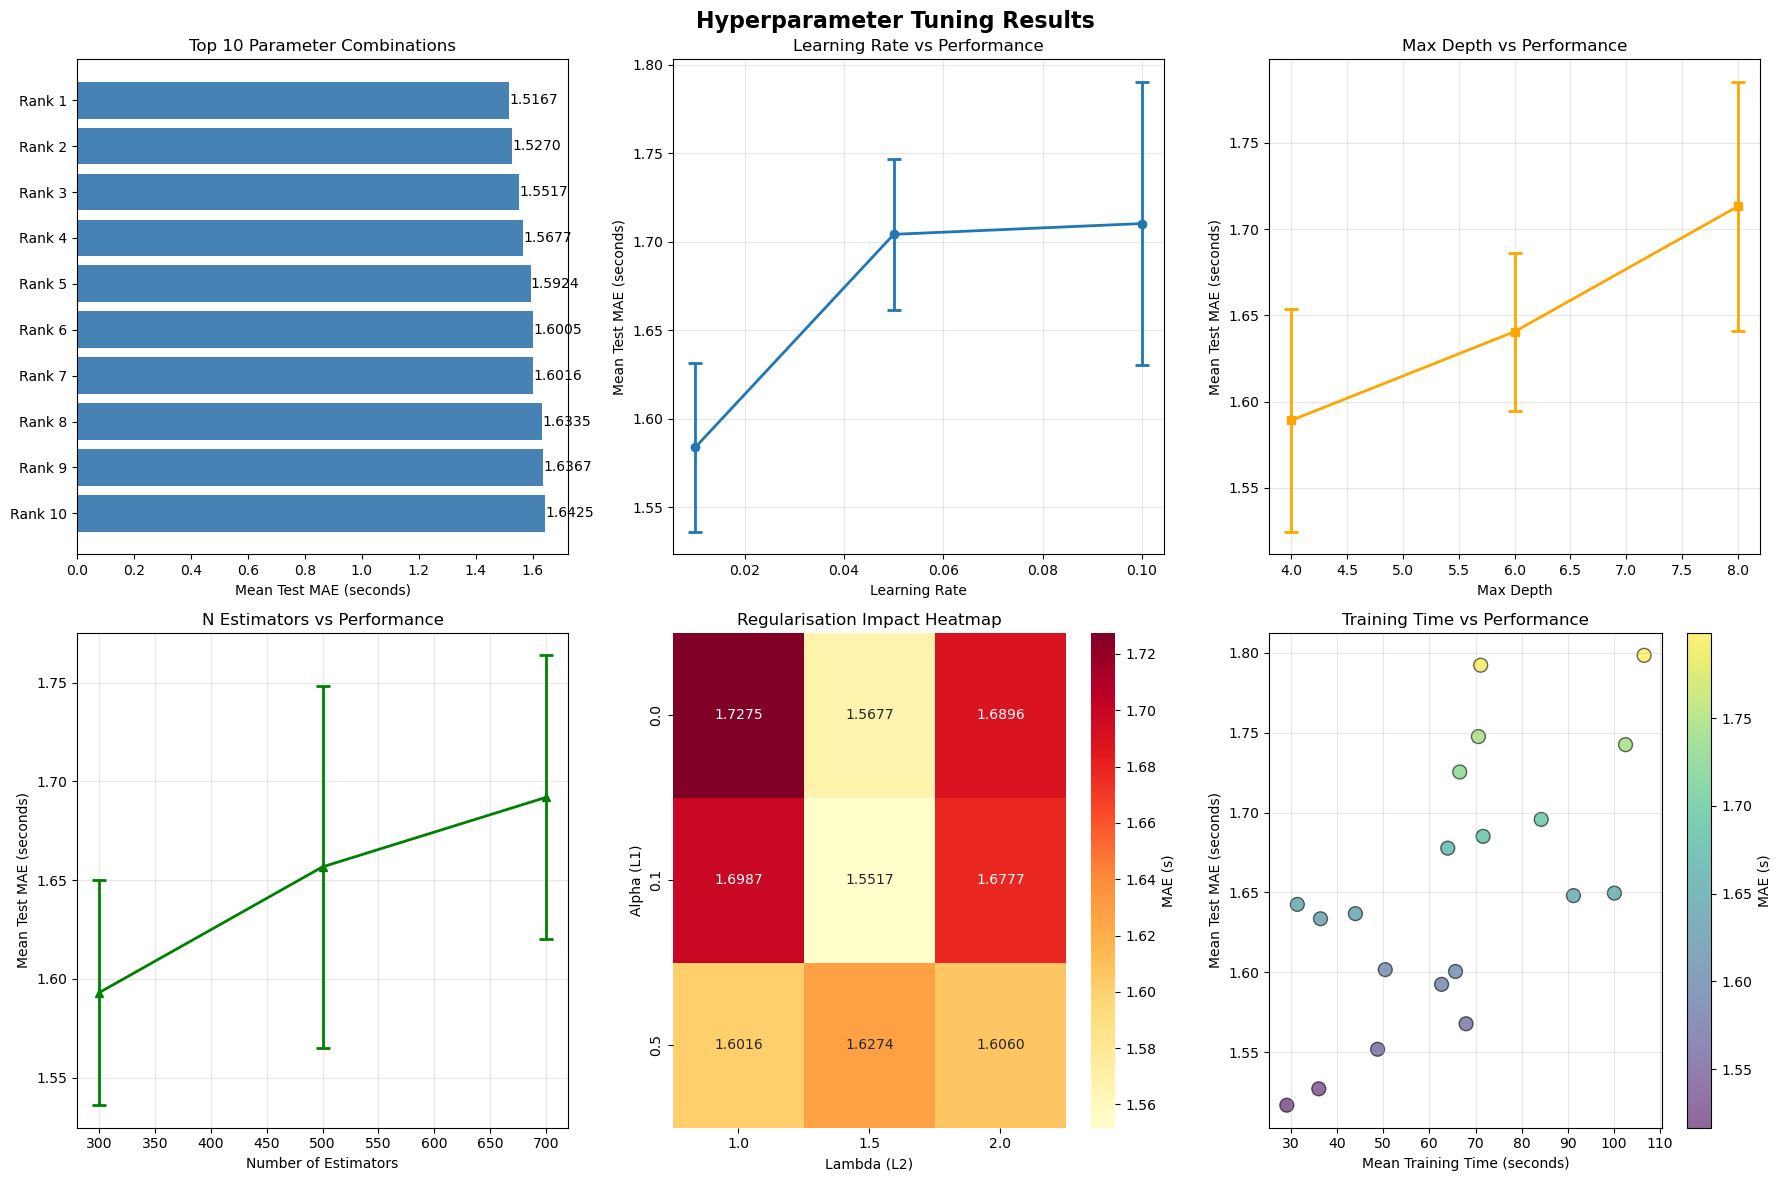


7. Baseline vs Tuned Model Comparison
Saved comparison to 'model_comparison.png'


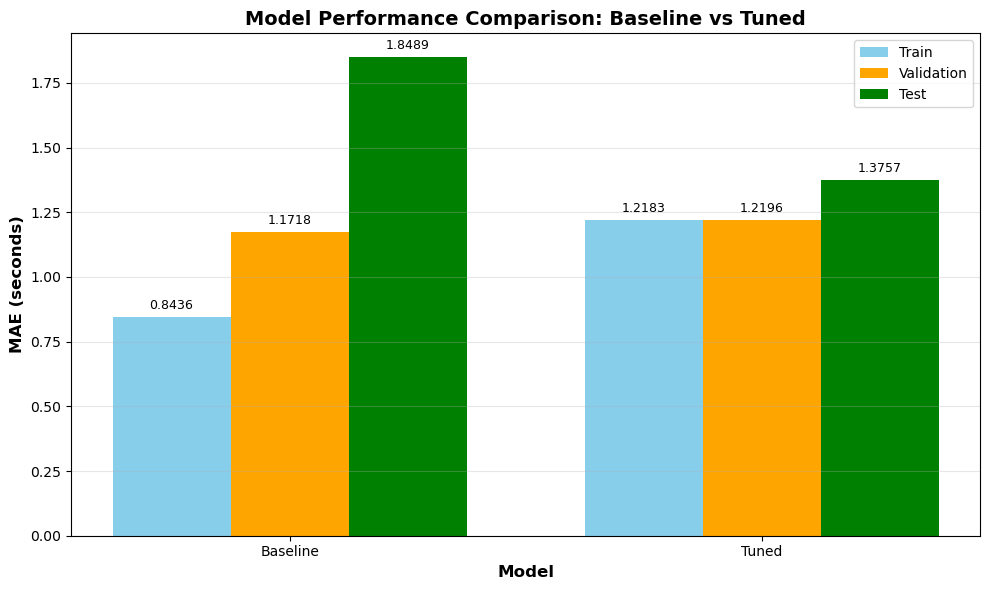

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyperparameter Tuning Results', fontsize=16, fontweight='bold')

# 1. Top 10 parameter combinations
print("\n1. Top 10 Parameter Combinations")
top_10 = results_df.nsmallest(10, 'rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'param_max_depth', 'param_learning_rate', 'param_n_estimators']
].copy()
top_10['mean_test_score'] = -top_10['mean_test_score']

ax = axes[0, 0]
ax.barh(range(len(top_10)), top_10['mean_test_score'], color='steelblue')
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels([f"Rank {int(r)}" for r in top_10['rank_test_score']])
ax.set_xlabel('Mean Test MAE (seconds)')
ax.set_title('Top 10 Parameter Combinations')
ax.invert_yaxis()
for i, v in enumerate(top_10['mean_test_score']):
    ax.text(v + 0.001, i, f'{v:.4f}', va='center')

# 2. Learning Rate vs MAE
print("2. Learning Rate Impact")
if 'param_learning_rate' in results_df.columns:
    lr_data = results_df.groupby('param_learning_rate')['mean_test_score'].agg(['mean', 'std']).reset_index()
    lr_data['mean'] = -lr_data['mean']
    
    ax = axes[0, 1]
    ax.errorbar(lr_data['param_learning_rate'], lr_data['mean'], 
                yerr=lr_data['std'], marker='o', capsize=5, capthick=2, linewidth=2)
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Mean Test MAE (seconds)')
    ax.set_title('Learning Rate vs Performance')
    ax.grid(True, alpha=0.3)

# 3. Max Depth vs MAE
print("3. Max Depth Impact")
if 'param_max_depth' in results_df.columns:
    depth_data = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std']).reset_index()
    depth_data['mean'] = -depth_data['mean']
    
    ax = axes[0, 2]
    ax.errorbar(depth_data['param_max_depth'], depth_data['mean'], 
                yerr=depth_data['std'], marker='s', capsize=5, capthick=2, linewidth=2, color='orange')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel('Mean Test MAE (seconds)')
    ax.set_title('Max Depth vs Performance')
    ax.grid(True, alpha=0.3)

# 4. N Estimators vs MAE
print("4. N Estimators Impact")
if 'param_n_estimators' in results_df.columns:
    est_data = results_df.groupby('param_n_estimators')['mean_test_score'].agg(['mean', 'std']).reset_index()
    est_data['mean'] = -est_data['mean']
    
    ax = axes[1, 0]
    ax.errorbar(est_data['param_n_estimators'], est_data['mean'], 
                yerr=est_data['std'], marker='^', capsize=5, capthick=2, linewidth=2, color='green')
    ax.set_xlabel('Number of Estimators')
    ax.set_ylabel('Mean Test MAE (seconds)')
    ax.set_title('N Estimators vs Performance')
    ax.grid(True, alpha=0.3)

# 5. Regularisation parameters
print("5. Regularisation Impact")
if 'param_reg_alpha' in results_df.columns and 'param_reg_lambda' in results_df.columns:
    reg_data = results_df.pivot_table(
        values='mean_test_score',
        index='param_reg_alpha',
        columns='param_reg_lambda',
        aggfunc='mean'
    )
    reg_data = -reg_data
    
    ax = axes[1, 1]
    sns.heatmap(reg_data, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'MAE (s)'})
    ax.set_xlabel('Lambda (L2)')
    ax.set_ylabel('Alpha (L1)')
    ax.set_title('Regularisation Impact Heatmap')

# 6. Training time vs Performance
print("6. Training Time vs Performance")
if 'mean_fit_time' in results_df.columns:
    ax = axes[1, 2]
    scatter = ax.scatter(
        results_df['mean_fit_time'],
        -results_df['mean_test_score'],
        c=-results_df['mean_test_score'],
        cmap='viridis',
        s=100,
        alpha=0.6,
        edgecolors='black'
    )
    ax.set_xlabel('Mean Training Time (seconds)')
    ax.set_ylabel('Mean Test MAE (seconds)')
    ax.set_title('Training Time vs Performance')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='MAE (s)')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualisation to 'hyperparameter_tuning_results.png'")
plt.show()

# 7. Baseline vs Tuned Comparison
print("\n7. Baseline vs Tuned Model Comparison")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

comparison_data = {
    'Model': ['Baseline', 'Tuned'],
    'Train MAE': [train_metrics['MAE'], tuned_train_mae],
    'Val MAE': [val_metrics['MAE'], tuned_val_mae],
    'Test MAE': [test_metrics['MAE'], tuned_test_mae]
}

x = np.arange(len(comparison_data['Model']))
width = 0.25

ax.bar(x - width, comparison_data['Train MAE'], width, label='Train', color='skyblue')
ax.bar(x, comparison_data['Val MAE'], width, label='Validation', color='orange')
ax.bar(x + width, comparison_data['Test MAE'], width, label='Test', color='green')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Baseline vs Tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_data['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for i, model in enumerate(comparison_data['Model']):
    ax.text(i - width, comparison_data['Train MAE'][i] + 0.02, 
            f"{comparison_data['Train MAE'][i]:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i, comparison_data['Val MAE'][i] + 0.02, 
            f"{comparison_data['Val MAE'][i]:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width, comparison_data['Test MAE'][i] + 0.02, 
            f"{comparison_data['Test MAE'][i]:.4f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved comparison to 'model_comparison.png'")
plt.show()

<h3> Load Pit Stop Data </h3>
I used openf1 for pit stop data to prepare the strategy predictor as the length of an average pit stop is based on strategy.

In [15]:
# Loading the stint data we already have
stints_df = pd.read_csv('openf1_stints.csv')

# Get unique sessions from stint data
unique_sessions = stints_df[['session_key', 'circuit_short']].drop_duplicates()

print(f"\n✓ Found {len(unique_sessions)} sessions to load pit stop data from")

# Fetching pit stop data for each session
all_pitstops = []

for idx, row in unique_sessions.iterrows():
    session_key = row['session_key']
    circuit = row['circuit_short']
    
    print(f"Loading pit stops for session {session_key} ({circuit})...", end=' ')
    
    url = f"https://api.openf1.org/v1/pit?session_key={session_key}"
    response = requests.get(url)
    
    if response.status_code == 200:
        pitstops = response.json()
        
        for pit in pitstops:
            pit['circuit'] = circuit
        
        all_pitstops.extend(pitstops)
        print(f"{len(pitstops)} stops")
    else:
        print(f"Error {response.status_code}")
    
    time.sleep(0.2)

# Converting to DataFrame
pitstops_df = pd.DataFrame(all_pitstops)

print(f"\n{'='*50}")
print(f"✓ Total pit stops loaded: {len(pitstops_df):,}")

# Calculating median pit stop time per circuit
circuit_pitstop_times = pitstops_df.groupby('circuit')['pit_duration'].median().reset_index()
circuit_pitstop_times.columns = ['Circuit', 'MedianPitStopTime']

print("\nCircuit pit stop times:")
print(circuit_pitstop_times.sort_values('MedianPitStopTime').to_string(index=False))

# Saving
circuit_pitstop_dict = circuit_pitstop_times.set_index('Circuit')['MedianPitStopTime'].to_dict()

# Overall average
overall_avg = pitstops_df['pit_duration'].median()
print(f"\nOverall median pit stop time: {overall_avg:.2f}s")

# Saving to CSV
pitstops_df.to_csv('openf1_pitstops.csv', index=False)
print(f"Saved to 'openf1_pitstops.csv'")




✓ Found 46 sessions to load pit stop data from
Loading pit stops for session 7953 (Sakhir)... 0 stops
Loading pit stops for session 7779 (Jeddah)... 0 stops
Loading pit stops for session 7787 (Melbourne)... 0 stops
Loading pit stops for session 9070 (Baku)... 0 stops
Loading pit stops for session 9078 (Miami)... 0 stops
Loading pit stops for session 9094 (Monte Carlo)... 0 stops
Loading pit stops for session 9102 (Catalunya)... 43 stops
Loading pit stops for session 9110 (Montreal)... 33 stops
Loading pit stops for session 9118 (Spielberg)... 63 stops
Loading pit stops for session 9126 (Silverstone)... 24 stops
Loading pit stops for session 9133 (Hungaroring)... 36 stops
Loading pit stops for session 9141 (Spa-Francorchamps)... 37 stops
Loading pit stops for session 9149 (Zandvoort)... 101 stops
Loading pit stops for session 9157 (Monza)... 25 stops
Loading pit stops for session 9165 (Singapore)... 25 stops
Loading pit stops for session 9173 (Suzuka)... 43 stops
Loading pit stops for 

<h3> Process Pit Stop Data </h3>

In [16]:
# Helper functions for pit stop handling
def create_pit_stop_dict(pitstops_df, outlier_threshold=40.0, default_time=20.0):
    valid_stops = pitstops_df[pitstops_df['pit_duration'] <= outlier_threshold]
    circuit_medians = valid_stops.groupby('circuit')['pit_duration'].median()
    pit_stop_dict = circuit_medians.to_dict()
    pit_stop_dict = {k: (v if pd.notna(v) else default_time) for k, v in pit_stop_dict.items()}
    pit_stop_dict['DEFAULT'] = default_time
    return pit_stop_dict

def get_pit_stop_time(circuit, pit_stop_dict, default=20.0):
    return pit_stop_dict.get(circuit, pit_stop_dict.get('DEFAULT', default))

# Create cleaned pit stop dictionary
pit_stop_dict = create_pit_stop_dict(pitstops_df, outlier_threshold=40.0, default_time=20.0)

print("\nCleaned pit stop times:")
for circuit, time in sorted(pit_stop_dict.items()):
    if circuit != 'DEFAULT':
        print(f"{circuit:30} {time:.2f}s")



Cleaned pit stop times:
Austin                         24.30s
Baku                           20.60s
Catalunya                      22.40s
Hungaroring                    21.80s
Imola                          30.10s
Interlagos                     23.90s
Jeddah                         22.10s
Las Vegas                      21.50s
Lusail                         28.65s
Melbourne                      17.90s
Mexico City                    22.60s
Miami                          22.60s
Monte Carlo                    24.20s
Montreal                       24.35s
Monza                          24.60s
Sakhir                         24.75s
Shanghai                       22.90s
Silverstone                    29.10s
Singapore                      29.70s
Spa-Francorchamps              23.20s
Spielberg                      21.65s
Suzuka                         23.50s
Yas Marina Circuit             22.00s
Zandvoort                      20.90s


<h3> Strategy Prediction </h3>

In [20]:
def simulate_race_strategy(driver, circuit, year, strategy, total_laps=50):
    
    predictions = []
    current_lap = 1
    
    for compound, stint_laps in strategy:
        for lap_in_stint in range(stint_laps):
            lap_number = current_lap + lap_in_stint
            tyre_life = lap_in_stint + 1
            
            # Creating feature vector
            features = {
                'Year': year,
                'LapNumber': lap_number,
                'Stint': len([s for s in strategy[:strategy.index((compound, stint_laps))]]) + 1,
                'TyreLife': tyre_life,
                'TyreLifeSquared': tyre_life ** 2,
                'StintLapNumber': lap_in_stint + 1,
                'EstimatedFuelKg': max(0, 110 - (lap_number * 3))
            }
            
            # Add team, driver, compound features
            for col in feature_columns:
                if col not in features:
                    if col == f'Driver_{driver}':
                        features[col] = 1
                    elif col == f'Compound_{compound}':
                        features[col] = 1
                    elif col.startswith('Team_') or col.startswith('Driver_') or col.startswith('Compound_'):
                        features[col] = 0
                    else:
                        features[col] = 0
            
            # Predicting lap time delta
            feature_vector = [features[col] for col in feature_columns]
            lap_delta = best_model.predict([feature_vector])[0]
            
            predictions.append({
                'Lap': lap_number,
                'Compound': compound,
                'TyreLife': tyre_life,
                'PredictedDelta': lap_delta
            })
            
        current_lap += stint_laps
    
    df = pd.DataFrame(predictions)
    total_time_delta = df['PredictedDelta'].sum()
    
    # Calculating pit stop time with outlier handling
    num_pitstops = len(strategy) - 1
    pit_time_per_stop = get_pit_stop_time(circuit, pit_stop_dict, default=20.0)
    pitstop_time = num_pitstops * pit_time_per_stop

    
    return df, total_time_delta, pitstop_time

# Example: Compare strategies for VER at Bahrain
print("\nStrategy Comparison: VER at Bahrain 2024\n")

strategies = {
    'One-Stop (MEDIUM → HARD)': [('MEDIUM', 25), ('HARD', 32)],
    'One-Stop (SOFT → HARD)': [('SOFT', 15), ('HARD', 42)],
    'Two-Stop (SOFT → MEDIUM → HARD)': [('SOFT', 15), ('MEDIUM', 20), ('HARD', 22)],
    'Two-Stop (MEDIUM → HARD → MEDIUM)': [('MEDIUM', 20), ('HARD', 20), ('MEDIUM', 17)]
}

results = []

for strategy_name, strategy in strategies.items():
    laps_df, total_delta, pitstop_time = simulate_race_strategy(
        driver='NOR',
        circuit='Bahrain',
        year=2024,
        strategy=strategy,
        total_laps=62
    )
    
    # Total race time = baseline + delta + pitstops
    baseline_race_time = 5400  # ~90min in seconds (placeholder)
    total_race_time = baseline_race_time + total_delta + pitstop_time
    
    results.append({
        'Strategy': strategy_name,
        'Total Delta': f"{total_delta:+.1f}s",
        'Pitstops': len(strategy) - 1,
        'Pitstop Time': f"{pitstop_time}s",
        'Total Time': f"{total_race_time:.1f}s"
    })
    
    print(f"{strategy_name}:")
    print(f"  Total delta: {total_delta:+.1f}s")
    print(f"  Pitstops: {len(strategy) - 1} ({pitstop_time}s lost)")
    print(f"  Estimated total time: {total_race_time:.1f}s")
    print()

# Show comparison table
results_df = pd.DataFrame(results)
print("\nStrategy Comparison:")
print(results_df.to_string(index=False))

# Find best strategy
best_idx = results_df['Total Time'].str.replace('s', '').astype(float).idxmin()
print(f"\nRecommended Strategy: {results_df.iloc[best_idx]['Strategy']}")



Strategy Comparison: VER at Bahrain 2024

One-Stop (MEDIUM → HARD):
  Total delta: +60.2s
  Pitstops: 1 (20.0s lost)
  Estimated total time: 5480.2s

One-Stop (SOFT → HARD):
  Total delta: +61.6s
  Pitstops: 1 (20.0s lost)
  Estimated total time: 5481.6s

Two-Stop (SOFT → MEDIUM → HARD):
  Total delta: +59.9s
  Pitstops: 2 (40.0s lost)
  Estimated total time: 5499.9s

Two-Stop (MEDIUM → HARD → MEDIUM):
  Total delta: +62.0s
  Pitstops: 2 (40.0s lost)
  Estimated total time: 5502.0s


Strategy Comparison:
                         Strategy Total Delta  Pitstops Pitstop Time Total Time
         One-Stop (MEDIUM → HARD)      +60.2s         1        20.0s    5480.2s
           One-Stop (SOFT → HARD)      +61.6s         1        20.0s    5481.6s
  Two-Stop (SOFT → MEDIUM → HARD)      +59.9s         2        40.0s    5499.9s
Two-Stop (MEDIUM → HARD → MEDIUM)      +62.0s         2        40.0s    5502.0s

Recommended Strategy: One-Stop (MEDIUM → HARD)
